# Modeling of Sprinkler's Dampening Effect on Fire
### Modeling and Simulation of Physical Systems Final Project
#### By William Luik

## Introduction

For my final project, I attempted to model a fire burning in a 5 by 5-meter room, and how a fire sprinkler system may dampen the effects. Although there are many rooms out there that are not 5 by 5 meters, this code is a fundamental model that can be used to make extrapolations about larger rooms by assuming a sprinkler covers each portion of the large room. As always there were such drawbacks with this project as there is no specific formula to represent the characteristics of fire. Like most objects in the real world, fire is a chaotic system with multiple initial conditions and parameters affecting it. For simplicity, I focused on measuring the heat release rate of the fire. Heat release rate, HRR for short, measures the intensity at which a fire releases energy. HRR is measured in Watts; however, due to the magnitude of the fire, I will be working in Kilowatts.


## Background
There is no specific motivation for this project. When looking for inspiration, I was laying in bed looking up at the ceiling. I noticed the fire sprinkler and how it is unnoticeably a part of every room we step into. I wondered how challenging it would be to model something so embedded into our life that we rarely stop to notice it. There was lots of data in some aspects of the project such as how much water is released from a fire sprinkler, but less information in facets such as how to properly model a water droplet engulfed in flames.


## Format
The project was split into a 'main file' and 4 separate files to simplify for convenience. I will highlight the key importance of each file and how it has to lead to a final representation. Along with the 'main file,' there is a file running an Ising Model, projectile motion simulation, water droplet iterations, and plotting functions.

The main data structure used for this project was an array. This is because I needed to hold information for each section in the room. To simplify the model, I divided the room into smaller subsections that help its position in the array. This position can vary between trials as the dimensions of the room and stepsize dividing the room can change. To create a more accurate model I could increase the number of times the room is divided; However, this will lead to longer computation times. 

## Main File
As highlighted by the name, the 'main file' is the most important section of the code. Although every file plays a crucial part, the 'main file' calls up the other files and drives the program. In addition, this file initializes the arrays and sets the initial conditions to later be called in each file.

The portion of the code below imports all of the needed libraries for the 'main file' in addition to setting some structure. The code sets the dimensions of the array and how the floor will be divided into a grid where the position will have a value in the arrays. The Ising array is initialized and first assumed that each position on the floor is not on fire. Next, we find the center of the room and position the sprinkler here. If I wanted to model a different room, I could change the dimensions of the room or the position of the sprinkler. By defining each variable the code is flexible to model more than a 5 by 5-meter room with the sprinkler directly in the middle.

Note: The code does not run in Jupyter Notebook because numpy may not be on the computer. If this is a problem then run the code in Spyder. 

In [71]:
# Install necessary libraries
!pip install numpy matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [41]:
import math
import numpy as np
# import Projectile_final
# import droplet_iter
import sys
from random import randrange
# import Ising_fire_spread
# import bar_plot
import matplotlib.pyplot as plt
from IPython.display import clear_output


#spatial demensions of array
#floor demensions
floor_width= 10 #width of room in meters
floor_length = 10 
#step size
dx= 1 
dy= 1
#actual demensions of array
Nx= int(floor_width/dx) 
Ny = int(floor_length/dy)


ising_floor= np.zeros((Nx,Ny)) #fire=-1 and not_fire=1
   

#set floor temperature all to the same number
for i in range(Nx):
    for j in range(Ny):
        ising_floor[i,j]= 1  #start all positions not on fire


height= 3  # in meters... 9.84 feet
#sprinkler position --> need to find center of array
x_center = (Nx+1)/2 -1 #subtract by one because arrays start at position zero
y_center =(Nx+1)/2 -1

Next, I set the position of the fire. In this example, the fire is 2 by 2 meters set in the middle of the room. This condition can change if the variables are changed. An error may occur if the position of the fire is at the edge of the room. If this were to happen then there will be values that are outside the range of the array, leading to an error. By placing the fire in the middle of the room, I will not have this problem.

In [42]:
#location of fire
fire_width = 2
fire_length= 2
#array dimensions
fire_Nx = int(fire_width/dx) 
fire_Ny = int(fire_length/dy)

x_fire_position = 5
y_fire_position= 5
fire_pos_list=[]
for i in range(x_fire_position - int(fire_Nx/2),x_fire_position + int(fire_Nx/2) ):
    for j in range(y_fire_position - int(fire_Ny/2), y_fire_position + int(fire_Ny/2)):
        fire_pos_list.append((i,j))
        ising_floor[i,j]=-1



Next, I set some initial conditions for the height of the room along with values for gravity and drag coefficients. These variables are applied to the projectile file to find the maximum distance that a water droplet can be projected out of the sprinkler. To run the file, I first provided the projectile motion file. This file applies an ivp function to solve a projectile motion with air drag ODE. The ivp function stops running once the droplet has reached the floor. I found the structure for this projectile motion file on GitHub.

### Projectile File

In [43]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class Projectile:
    def __init__(self,k,m,height,v0):
        self.k=k
        self.m=m
        self.height=height
        self.v0=v0
        
    def k_value(self, c,rho_air,r ):
        A = np.pi * self.r**2
        k = 0.5 * self.c * self.rho_air * A
        return k

    def x_distance_time(self):
        def deriv(t, u):
            x, xdot, z, zdot = u
            speed = np.hypot(xdot, zdot)
            xdotdot = -self.k/self.m * speed * xdot
            zdotdot = -self.k/self.m * speed * zdot - g
            return xdot, xdotdot, zdot, zdotdot

        # Initial conditions: x0, v0_x, z0, v0_z.
        u0 = 0, self.v0 , self.height, 0
        # Integrate up to tf unless we hit the target sooner.
        t0, tf = 0, 50

        def hit_target(t, u):
            # We've hit the target if the z-coordinate is 0.
            return u[2]
        # Stop the integration when we hit the target.
        hit_target.terminal = True
        # We must be moving downwards (don't stop before we begin moving upwards!)
        hit_target.direction = -1

        def max_height(t, u):
            # The maximum height is obtained when the z-velocity is zero.
            return u[3]

        soln = solve_ivp(deriv, (t0, tf), u0, dense_output=True,
                         events=(hit_target, max_height))

        # A fine grid of time points from 0 until impact time.
        t = np.linspace(0, soln.t_events[0][0], 100)
        sol = soln.sol(t)
        x = sol[0]
        #final value
        xmax = x[-1]
        tmax= soln.t_events[0][0]
        return xmax, soln.t_events[0][0]

    
def methods():
    print("projectile")



In [44]:
#kinnematics-->add drag and variable velocity
height= 3  # in meters... 9.84 feet
g=9.
vx= 7
vy=0
c = 0.47   #drag coeffient of a sphere
r = .001   #radius of water droplet is 1mm
A = np.pi * r**2  #area of water droplet
m = 0.05  #mass of the water droplet
# Air density (kg.m-3), acceleration due to gravity (m.s-2).
rho_air = 1.28  #air coeffient
k = 0.5 * c * rho_air * A
#time_fall = math.sqrt(2*height/g) --> this if there was no drag
#projectile_d= vx* time_fall #how far the water droplet can shoot -->this if there is no drag

#Find the maximum distance that the water droplet can travel with linear drag in 2d
#I am importing code from Projectile_final to solve projectile motion with linear drag in the x and z directions
# max_drop_distance, max_drop_time= Projectile_final.Projectile(k,m,height,vx).x_distance_time()
max_drop_distance, max_drop_time= Projectile(k,m,height,vx).x_distance_time()
print("max distance", max_drop_distance)

max distance 5.715258577505534


Then, I simply set some inital conditions that will be implemented in the ising model. Importantly, the num_steps variable is how many iterations of the ising model that are implemented every second the the model is ran for. 

In [45]:

J= 1.0 #coupling coefficent of Ising model
J_diag= J/2  #coupling constant on the neighbors to the diagonal 
T=60  #temperature of Ising model. This will vary the entropy of the system
num_steps=300   #step iterated through the ising model. I will increment through a small # of steps, then look at what is on fire, then repeat


Here I am setting the time component of the model. For this code, I will be modeling the fire for 300 seconds, iterating through the code once each second. The np.linspace function will make an array of values representing each second between 1 and 300.

In [46]:
time_step= 1
final_time= 300
t =np.linspace(0, final_time, int(final_time/time_step + 1))
t

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Then, I initialized some important arrays before starting the driving iterator. First, the floor_time array will hold the start times that each position first became on fire. This array is important because each position of the array that is in flames will have its peak HRR at different times. The rise and fall of the HRR for each position are dependent on when it first catches fire.

Second, the floor_hrr array will hold the heat release rate values for each position on the floor. This array will later be used to create the heat map of the floor.

Third, the floor_water array will collect the total amount of energy due to water that lands in each position.  

In [47]:
floor_time= np.zeros((Nx, Ny))
floor_hrr=np.zeros((Nx, Ny))
floor_water= np.zeros((Nx,Ny))

Before I implement the driving iterator, I must first introduce the additions files so that the code all runs smoothly. 

### Ising Model File

First, the Ising model file will be implemented to the driving iterator because every second the fire will spread. In reality, the fire is spreading continually and not at discrete time steps. I used the structure of the Ising model from our class's Ising model project. the major difference is that a position in the array in question may flip its spin due to the interaction with a position to its diagonal. Normally in an Ising model, the positions above, below, to the left, and the right can affect the spin-flip. However since fire can spread from any sort of touch, therefore the diagonal positions must be accounted for as well. The other major difference is that the positions can only flip to -1 but not back to 1. This means that once a position is on fire it will not quickly become not on fire. This makes intuitive sense because surrounding positions that are not on fire do not incline a position that is on fire to somehow stop burning. Fire is contagious, while a non-fire state is not.

A possible way to improve my code is to change the Ising model in which fire positions can stop being on fire. The condition that would switch fire to non-fire would be when the HRR returns back to zero.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

class Fire:
    def __init__(self, ising_floor, Nx, Ny, J, J_diag, T, num_steps ):
        self.ising_floor=ising_floor
        self.Nx= Nx
        self.Ny= Ny
        self.J=J
        self.J_diag= J_diag
        self.T=T
        self.num_steps=num_steps
        
    def ising_model(self):
        # floor is given through as a parameter of the function

        # Calculate the initial energy and magnetization
        E = -self.J * np.sum(self.ising_floor * np.roll(self.ising_floor, -1, axis=0) +
                       self.ising_floor * np.roll(self.ising_floor, -1, axis=1))
        M = np.sum(self.ising_floor)


        # Perform the Monte Carlo simulation
        for i in range(self.num_steps):
            # Choose a random spin to flip
            row = np.random.randint(self.Nx)
            col = np.random.randint(self.Ny)

            # Calculate the energy change if the spin is flipped
            delta_E = 2 * self.J * self.ising_floor[row, col] * (
                self.ising_floor[row, (col+1)%self.Ny] + self.ising_floor[row, (col-1)%self.Ny] +
                self.ising_floor[(row+1)%self.Nx, col] + self.ising_floor[(row-1)%self.Nx, col]) + 2*self.J_diag*self.ising_floor[row,col]*(
                self.ising_floor[(row+1)%self.Nx, (col+1)%self.Ny] + self.ising_floor[(row-1)%self.Nx, (col+1)%self.Ny] + 
                self.ising_floor[(row-1)%self.Nx, (col-1)%self.Ny] + self.ising_floor[(row+1)%self.Nx, (col-1)%self.Ny] )

        # Accept or reject the spin flip based on the Metropolis algorithm
        if (delta_E < 0 or np.exp(-delta_E / self.T) > np.random.rand()) and  self.ising_floor[row,col]!=-1:  #no spin flip is there is already a fire
            self.ising_floor[row, col] *= -1
            E += delta_E
            M += 2 * self.ising_floor[row, col]
           
        # Plot the floor
        #plt.imshow(self.ising_floor, cmap='RdYlGn')  #note: black is -1 while white is 1
        #plt.show()
        return self.ising_floor



### Droplet Iterator
The next file that must be introduced is the droplet iterator file. This file finds exactly how many droplets are ejected out of the sprinkler each second and projects where it lands. The number of droplets per second, $50,000$, was found by first finding the number of liters per minute released. I was able to convert this to droplets per second by assuming that this is pure $H_2O$ and therefore $1 ml$ of water has a mass of $1g$. Also, via Google search, I needed to learn that a droplet has a mass of about $0.05g$. Once I know that there are $50,000$ droplets released every second, I randomize the distance and direction in which each droplet is projected. I use the max droplet distance from the projectile motion file. I randomized the projection by importing the random library. When the array lands in a specific position on the floor, the droplet is accounted for in the floor_water array.

Importantly, the energy of each droplet is calculated. To find this value I used the specific heat formula from Physics 112. At the end of each iteration, the amount of energy that is collected in each position in the floor_water array will reduce the HRR in that location.



In [49]:
import matplotlib.pyplot as plt
import numpy as np
import math
from random import randrange

class Droplet:
    def __init__(self, Nx, Ny, max_drop_distance, x_center, y_center,dx,dy ):
        self.Nx= Nx
        self.Ny=Ny
        self.max_drop_distance= max_drop_distance
        self.x_center=x_center
        self.y_center= y_center
        self.dx=dx
        self.dy=dy
        
        
    def drop_energy(self):
        #use the specific heat formula to find the energy from each water droplet
        m= 0.00005 # mass of a water droplet in kg
        c=4.186 # specific heat of water
        temp0= 15 #inital temp of water when it is released from sprinkler
        temp_final= 100 #boiling point of water
        delt_temp= temp_final-temp0
        heat_energy= m*c*delt_temp/1000 #divide by 1000 so that it is in kilo jouls
        return heat_energy
        
    def droplets(self):
        #collect all of the water droplets into each position on the array
        floor_water= np.zeros((self.Nx,self.Ny))
        
        for droplet in range(500):  #should be 33333 iterations but instead I am assuming that the drop has a value of 100 drops so that the iteration is quicker.
            #find the position of a random droplet
            drop_distance= randrange(1,int(self.max_drop_distance))  #this will be a random distance up to three decimal places
            projection_angle= randrange(0,360)  #angle zero is directly to the right --> later wil convert to radians
            xdrop_distance= math.cos(projection_angle * (math.pi/ 180)) *drop_distance
            ydrop_distance= math.sin(projection_angle * (math.pi/ 180)) *drop_distance

            #position of the random water droplet
            xdrop_position= int(self.x_center + (xdrop_distance)/self.dx)
            ydrop_position= int(self.y_center + (ydrop_distance)/self.dy)
        
            #energy of the droplet that landed in that position 'bucket'
            floor_water[xdrop_position,ydrop_position] += self.drop_energy() *100 #multiply by 100 to account for the reduction in iteration. itterating less but assuming that the random droplet has the energy of 100 droplets

        return floor_water
        

### Plotting File
The final file that must be introduced is the plotting file. This file has two functions; either plot a heatmap or create a bar plot. These will make a visual aid to help understand the HRR as it changes over each time iteration.


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # for data visualization

class Bar:
    def __init__(self,floor_hrr , Nx, Ny):
        self.floor_hrr = floor_hrr
        self.Nx= Nx
        self.Ny=Ny
    
    def heatmap(self):
        plt.imshow(self.floor_hrr, cmap='coolwarm')
        plt.colorbar()
        plt.title( "Heat Map of HRR on Floor (Meters)" )
        #plt.savefig("heatmap_video.png")
    

        #test_array = np.arange(self.Nx * self.Ny).reshape(self.Nx, self.Ny)
        return plt.show()
        
    def plot_bar(self):
        fig = plt.figure()
        ax = plt.axes(projection = "3d")

        numOfCols= self.Nx
        numOfRows= self.Ny

        xpos = np.arange(0, numOfCols, 1)
        ypos = np.arange(0, numOfRows, 1)
        xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
 
        xpos = xpos.flatten()
        ypos = ypos.flatten()
        zpos = np.zeros(numOfCols * numOfRows)
 
        dx = np.ones(numOfRows * numOfCols) * 0.5
        dy = np.ones(numOfCols * numOfRows) * 0.5
        dz = self.floor_hrr.flatten()
 
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
        ax.set_xticklabels(list(range(self.Nx)))
        ax.set_yticklabels(list(range(self.Ny)))
    
        ax.set_xlabel('Depth of room (meters)')
        ax.set_ylabel('Width of room (meters)')
        ax.set_zlabel('HRR (kilo Jouls)')
        #plt.savefig("bar_plot.png")
        
        return plt.show()


## The Driving Iterator

Last but not least, the driving iterator must be implemented. This embedded for loop will iterate over each second and will look at each position in the array. Since the arrays are all the same size, the iterator will be able to look at each array (floor_hrr, floor_water, floor_time, and ising_floor). First, the code creates a heatmap, calls the rising floor file to have the fire spread some, and projects the $50,000$ water droplets adding energy to the floor_water array.

Next, the iterator will look through each position in the array. First, the code will find any position that is now on fire and was not in the prior iteration. These newly ignited positions will have time recorded in the floor_time array so that I can calculate how long the position has been on fire. Second, the code tracked the HRR value of each position that is considered on fire. The long formula used to calculate the HRR over time was found in a publication by the US Department of Commerce on the heat release rate characteristics for different sources found in a nuclear power plant. This paper provided data such as the peak HRR and when it would occur. By plotting my graph with the provided information and using Microsoft Excel, I was able to derive an equation representing the HRR as a function of time.

Finally, I will subtract the amount of water energy in the floor_water array from each corresponding position's HRR. This is one of the best possible ways to analyze the effect of water on a fire.

All of these actions will repeat every second until the simulation is complete. 

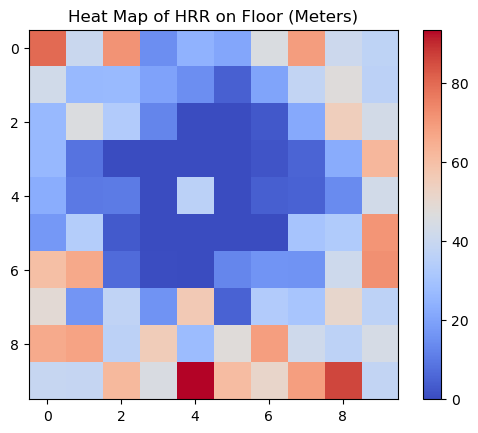

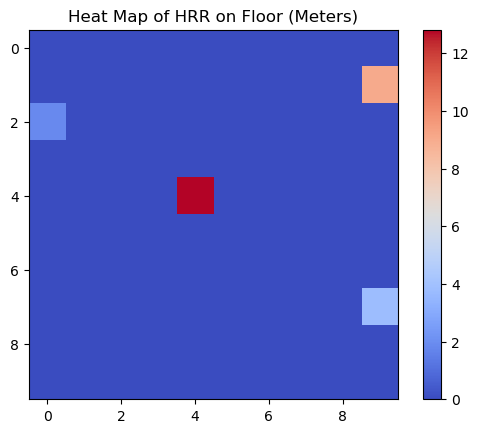

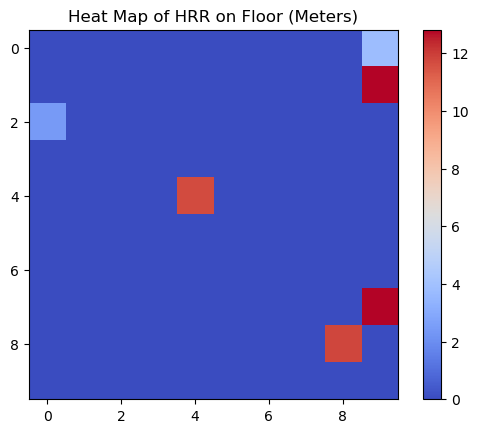

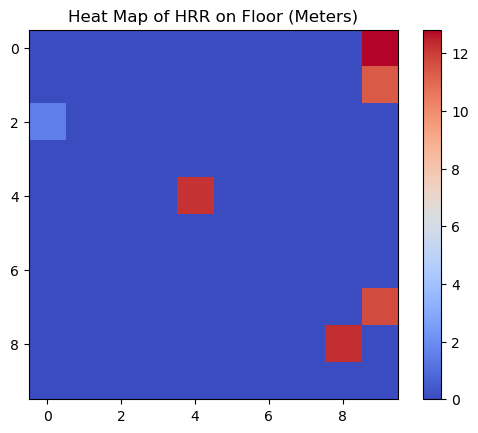

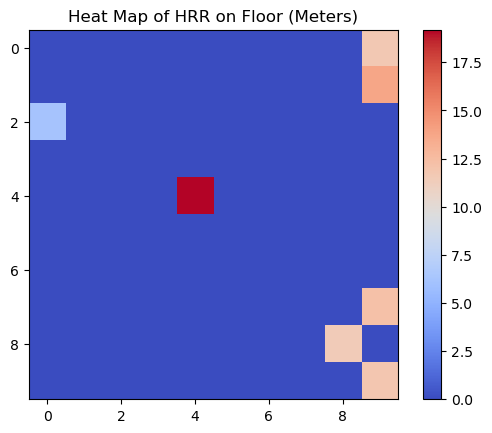

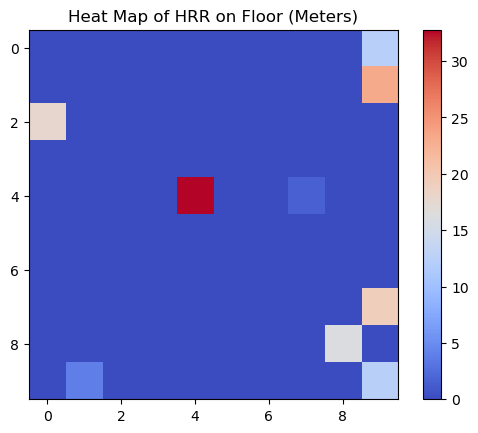

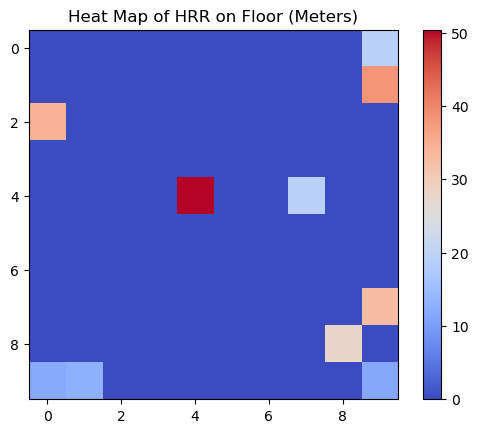

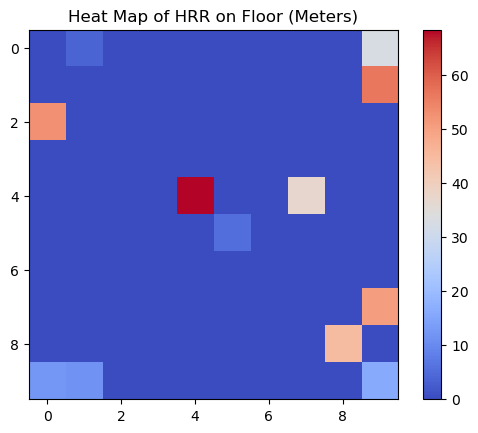

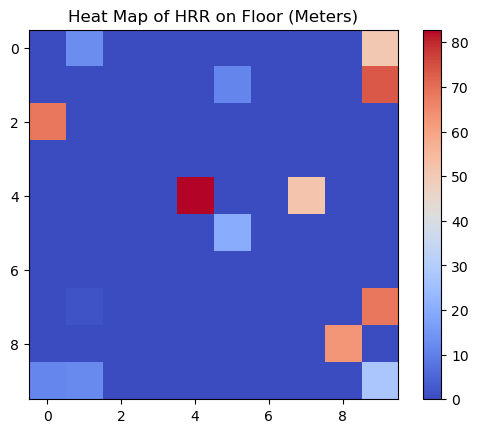

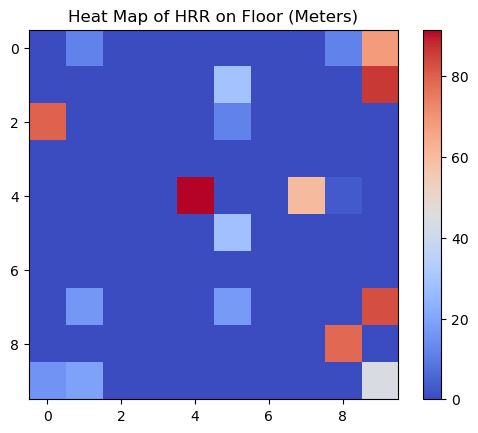

In [60]:
for time in t:  
    # bar_floor= bar_plot.Bar(floor_hrr, Nx, Ny).heatmap()
    if time <50 and time %5 ==0 :
        bar_floor= Bar(floor_hrr, Nx, Ny).heatmap()
    # ising_floor = Ising_fire_spread.Fire(ising_floor, Nx, Ny, J, J_diag, T, num_steps).ising_model() #spread the fire a little bit for what would be one second
    ising_floor = Fire(ising_floor, Nx, Ny, J, J_diag, T, num_steps).ising_model() #spread the fire a little bit for what would be one second
    # floor_water+=droplet_iter.Droplet(Nx, Ny, max_drop_distance, x_center, y_center, dx, dy).droplets()
    floor_water+=Droplet(Nx, Ny, max_drop_distance, x_center, y_center, dx, dy).droplets()
    for i in range(Nx):
        for j in range(Ny): #look through all the positions for new fire so that we can start the HRR polynomial
            if (ising_floor[i,j]== -1) and ((i,j) not in fire_pos_list):  # if there is a NEW fire in this location 
                fire_pos_list.append((i,j))  #postions of all arrays on fire
                floor_time[i,j]= time  #this will state the start time of the fire
                time_on_fire= time- floor_time[i,j]
            elif (ising_floor[i,j]==-1):  #if there is just a fire in this location that has already been here
                time_on_fire= time -floor_time[i,j]
            else: #if position is not on fire
                time_on_fire=0
                
            if ising_floor[i,j]==-1: #find HRR which is in kilo Wats (multiply by Nx and Ny to get ride of meters squared)
                if time <= 35:
                    floor_hrr[i,j]= dx * dy* ((-6*10**-7 * time_on_fire**6)+ (1*10**-4 * time_on_fire**5) + (-0.0058 * time_on_fire**4)+ (0.1399 * time_on_fire**3) -1.225 *time_on_fire**2 + (3.822 *time_on_fire)+9.041)   
                else: 
                    floor_hrr[i,j]=86 - 0.2*(time_on_fire-50)
                    
                floor_hrr[i,j]-= floor_water[i,j]
                if floor_hrr[i,j]<=0:
                    floor_hrr[i,j]=0
                

          

In the end, a couple more plots are created along with some print statements. These actions are not vital to the code but were extremely helpful in debugging and providing final information about the fire.

/var/folders/gn/3r943ckd7lxgnszvkxwsnx2c0000gn/T/ipykernel_45666/4087155758.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(self.Nx)))
/var/folders/gn/3r943ckd7lxgnszvkxwsnx2c0000gn/T/ipykernel_45666/4087155758.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(self.Ny)))


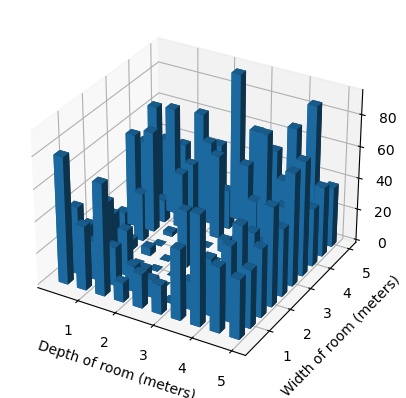

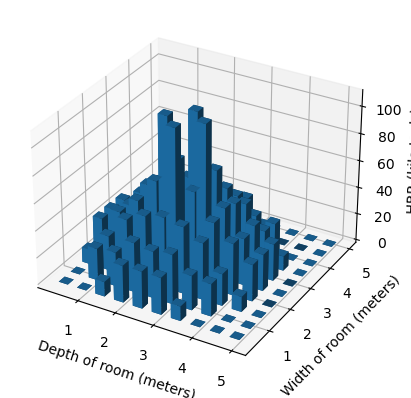

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[218.  21. 225.  18.  65.  48.  95. 166.  25.   6.]
 [ 32.  59.  68.  84.  49.   7.  37. 119.  57.   2.]
 [  1. 165. 175. 103.  39.   8.  22.  35. 144.  36.]
 [ 74.  27.  12.  26.  52.  53.  52.  20.  54. 131.]
 [ 56.  24. 112.  19.   0.   0.  79.   0.  13.  34.]
 [ 29. 153.  58. 120.   0.   0.  17. 138. 107. 174.]
 [168. 266.  44.  45.  49. 106.  88.  14.  76. 180.]
 [ 64.  11. 121.  64. 261.   9. 102.  81.  74.   3.]
 [149. 158.  50. 217.  80. 181. 212.  28.   4.  40.]
 [ 16.  15. 130.  46. 287. 123.  77. 164. 250.  10.]]


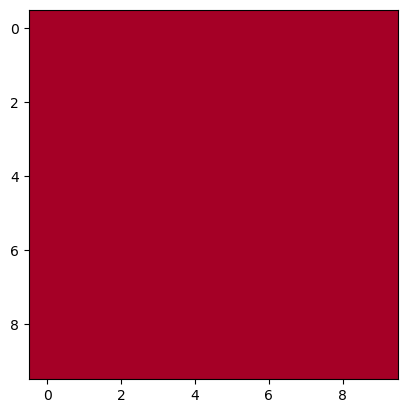

In [70]:
# bar_floor= bar_plot.Bar(floor_hrr, Nx, Ny).plot_bar()
bar_floor= Bar(floor_hrr, Nx, Ny).plot_bar()
# water_graph= bar_plot.Bar(floor_water, Nx, Ny).plot_bar()
water_graph= Bar(floor_water, Nx, Ny).plot_bar()


#print(fire_pos_list)
print(ising_floor)
#print (floor_hrr)  #in kilo jouls
print(floor_time)
#print(floor_water)


plt.imshow(ising_floor, cmap='RdYlGn')  #note: black is -1 while white is 1
plt.show()


## Drawbacks/Improvements

As mentioned in the introduction, the biggest challenge was learning about the science of fire. This is not a widely acknowledged subfield in physics and it becomes very chaotic very quickly. Using the energy of water to reduce the HRR of the fire is a respectable analysis; however, this does not account for the fact that the water creates a wet surface that inhibits the fire from flourishing. The only way to improve my analysis in this sense is to completely change the equations used to model fire. This is challenging but not impossible. The US Department of Commerce mentioned a formula:
$$ \dot{Q}=\dot{m} * H_{T} * x_{A}$$

Where $\dot{Q}$ is the rate of heat release based on mass loss. $\dot{m}$ is the rate of mass loss (kg/s). $H_{T}$ is the net heat of complete combustion (KJ/g). $x_{A}$ is the combustion efficency.

Another way to improve the code would be to change the layout of the room. At the moment, each position of the room burns at the same rate. In reality, this is not true because rooms have furniture in some positions which will have a greater peak HRR compared to the area that is empty and only the hardwood floor is burning. To change this I would have to have different HRR concerning time functions for differing positions.

## Conclusion
In conclusion, I found this simulation a success. The code ran smoothly and produced respectable data. My simulation may not be the same as experimental data, but that is because there is chaos in the real world which is somewhat impossible to account for. The physics of fire is rarely incorporated in academia and I believe my code could be a great introduction to both physics coupled with fire along with physics implemented in Python.


### References

HRR data: https://nvlpubs.nist.gov/nistpubs/Legacy/IR/nbsir85-3195.pdf 

HRR info: https://doctorfire.com/heat-release-rate-a-brief-primer/ 

Sprinkler info: https://www.marysvillefiredistrict.org/public-education/home-fire-sprinklers/how-fire-sprinklers-work/#:~:text=Fire%20hoses%20use%20about%20250,to%20put%20out%20a%20fire. 
